## EES4408 Project

In [1]:
#########################################################
#################### START: OWN CODE ####################
#########################################################

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import cluster

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read file
data = pd.read_excel('./data.xlsx')
data.head()

,Date,Contest number,Word,Number of reported results,Number in hard mode,1 try,2 tries,3 tries,4 tries,5 tries,...,encode_4,encode_5,vowel_num,e12,t9,a8,o7,i7,n7,dup_num
0,44926,560,manly,20380,1899,0,2,17,37,29,...,12,25,1,0,0,1,0,0,1,0
1,44925,559,molar,21204,1973,0,4,21,38,26,...,1,18,2,0,0,1,1,0,0,0
2,44924,558,havoc,20001,1919,0,2,16,38,30,...,15,3,2,0,0,1,1,0,0,0
3,44923,557,impel,20160,1937,0,3,21,40,25,...,5,12,2,1,0,0,0,1,0,0
4,44922,556,condo,20879,2012,0,2,17,35,29,...,4,15,2,0,0,0,1,0,1,1


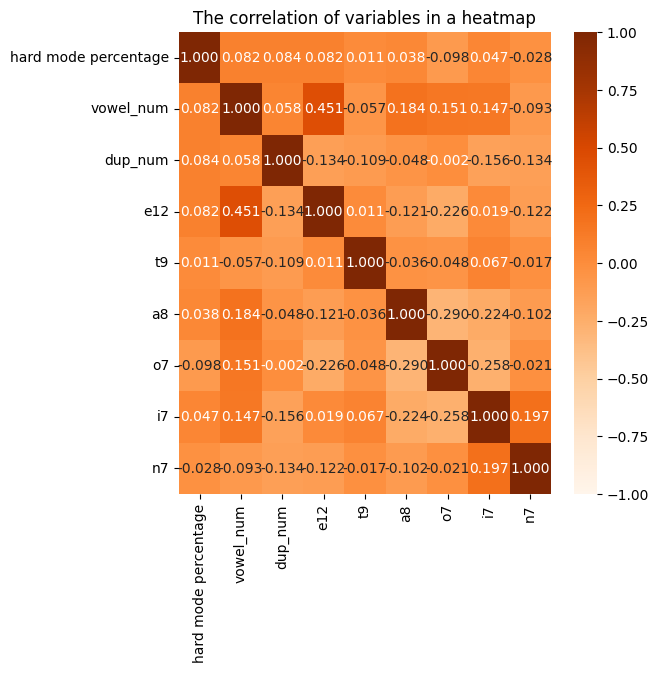

In [4]:
# Correlation map
corr_attribute = data[['hard mode percentage', 'vowel_num', 'dup_num', 'e12', 't9', 'a8', 'o7', 'i7', 'n7']]
corr = corr_attribute.corr()
# Heatmap
plt.subplots(figsize=(6,6))
sns.heatmap(corr, vmin = -1, vmax = 1, annot=True, fmt='.3f', cmap = 'Oranges')
plt.title('The correlation of variables in a heatmap')
plt.show()

In [5]:
# Problem 1

# Build multiple inputs and multiple outputs
X = data[['hard mode percentage', 'encode_1', 'encode_2', 'encode_3', 'encode_4', 'encode_5', 'vowel_num', 'dup_num', 'e12', 't9', 'a8', 'o7', 'i7', 'n7']]
Y = data[['1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7 or more tries (X)']]
# Setting of training set and test set, test set accounts for 10%
tr_x,te_x,tr_y,te_y=train_test_split(X,Y,test_size=0.1,random_state=5)
# Mean absolute error
def MAE(actual, pred):
    return np.mean(np.abs(actual - pred))

In [6]:
# Linear regression
model_lr=RegressorChain(LinearRegression())
model_lr.fit(tr_x,tr_y)
print("Linear regression:")
print("Mean absolute error of training and testing set")
dict_keys = ['1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7 or more tries (X)']
MAE_lr = dict.fromkeys(dict_keys, None)

# Predict
trX_Y=model_lr.predict(tr_x)
tre_Y=model_lr.predict(te_x)

# MAE
for i in range(7):
    MAE_lr[dict_keys[i]] = [MAE(trX_Y[:,i].reshape(-1,1), tr_y.values[:, i].reshape(-1, 1)), MAE(tre_Y[:,i].reshape(-1,1), te_y.values[:, i].reshape(-1, 1))]
    
MAE_lr_df = pd.DataFrame(MAE_lr, index=['Train', 'Test'])
MAE_lr_df

Linear regression:
Mean absolute error of training and testing set


,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
Train,0.398949,2.235824,5.023529,3.850355,3.848730,4.170287,2.201394
Test,0.537537,2.816582,5.903289,3.282952,4.279671,4.706402,2.342714


In [7]:
# Random forest
rf_depth = [5, 10, 15]
rf_est = [50, 300, 500, 800]
# Array to record, 1st -> n tries MAE, 2nd -> n depth, 3rd -> n estimators, 4th -> train/test
MAE_rf = np.zeros((7, len(rf_depth), len(rf_est), 2))

# Train
for i_depth,depth in enumerate(rf_depth):
    for i_ests,ests in enumerate(rf_est):
        model_rf=RegressorChain(RandomForestRegressor(max_depth=depth,n_estimators=ests,random_state=0))
        model_rf.fit(tr_x,tr_y)   
        
        # Predict
        trX_Y=model_rf.predict(tr_x)
        tre_Y=model_rf.predict(te_x)
        
        # MAE
        for i in range(7):
            MAE_rf[i, i_depth, i_ests, 0] = MAE(trX_Y[:,i].reshape(-1,1), tr_y.values[:, i].reshape(-1, 1))
            MAE_rf[i, i_depth, i_ests, 1] = MAE(tre_Y[:,i].reshape(-1,1), te_y.values[:, i].reshape(-1, 1))

In [8]:
# MAE
n_tries = ['1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7 or more tries (X)']
n_depth = [str(i) for i in rf_depth]
n_est = [str(i) for i in rf_est]
print("Random forest:")
print("Mean absolute error of training and testing set")

# Deepest and most estimators
print("\nDepth: 10, 800 estimators")
MAE_rf_df = pd.DataFrame(MAE_rf[:, 1, 3, :].T, columns=n_tries, index=['Train', 'Test'])
MAE_rf_df

Random forest:
Mean absolute error of training and testing set

Depth: 10, 800 estimators


,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
Train,0.160930,0.886972,2.701088,2.528144,2.166266,2.576335,1.286042
Test,0.421124,2.571727,5.027800,3.742254,4.107128,4.252042,1.703398


In [9]:
# Depth in train
print("In training set, different depths. (500 estimators)")
MAE_rf_depth_train_df = pd.DataFrame(MAE_rf[:, :, 2, 0].T, columns=n_tries, index=n_depth)
MAE_rf_depth_train_df

In training set, different depths. (500 estimators)


,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
5,0.259762,1.830526,4.717314,3.773708,3.554200,4.046390,1.712167
10,0.161477,0.850565,2.658122,2.526925,2.158641,2.546484,1.312802
15,0.147061,0.794792,2.480242,2.264113,2.050390,2.367218,1.210151


In [10]:
# Depth in test
print("In testing set, different depths. (500 estimators)")
MAE_rf_depth_test_df = pd.DataFrame(MAE_rf[:, :, 2, 1].T, columns=n_tries, index=n_depth)
MAE_rf_depth_test_df

In testing set, different depths. (500 estimators)


,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
5,0.414610,2.876271,5.458633,3.558455,4.732272,4.373281,1.718370
10,0.420176,2.579491,4.895555,3.746755,4.077296,4.138264,1.693424
15,0.424305,2.581407,5.023807,3.774962,4.149968,4.217389,1.710278


In [11]:
# Estimators in train
print("In training set, different estimators. (depth: 10)")
MAE_rf_est_train_df = pd.DataFrame(MAE_rf[:, 1, :, 0].T, columns=n_tries, index=n_est)
MAE_rf_est_train_df

In training set, different estimators. (depth: 10)


,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
50,0.164800,1.015148,2.799619,2.673849,2.229937,2.664442,1.290570
300,0.160306,0.852335,2.721504,2.523656,2.169069,2.603983,1.289896
500,0.161477,0.850565,2.658122,2.526925,2.158641,2.546484,1.312802
800,0.160930,0.886972,2.701088,2.528144,2.166266,2.576335,1.286042


In [12]:
# Estimators in test
print("In testing set, different estimators. (depth: 10)")
MAE_rf_est_test_df = pd.DataFrame(MAE_rf[:, 1, :, 1].T, columns=n_tries, index=n_est)
MAE_rf_est_test_df

In testing set, different estimators. (depth: 10)


,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X)
50,0.413767,2.859294,5.182912,4.085274,4.471576,4.292732,1.737660
300,0.425812,2.637768,5.106645,3.894325,4.276358,4.303675,1.729026
500,0.420176,2.579491,4.895555,3.746755,4.077296,4.138264,1.693424
800,0.421124,2.571727,5.027800,3.742254,4.107128,4.252042,1.703398


In [13]:
# Problem 2

# Data feature
cluster_attribute = data[['1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7 or more tries (X)', 'hard mode percentage']]

# PCA
sampFeature = cluster_attribute.values
# Covariance
covMat = np.cov(sampFeature, rowvar=0) # Each row is one sample
# Eigenvalues
pca_num = 2
eigVals, eigVects = np.linalg.eig(np.mat(covMat))
# 2 largest
eigValIndice = np.argsort(eigVals)
n_eigValIndice = eigValIndice[-1:-(pca_num+1):-1]
n_eigVect = eigVects[:,n_eigValIndice]

print('Eigenvalues:', np.round(eigVals, 1))

Eigenvalues: [139.2  42.1   9.8   3.4   1.4   0.4   0.3   0. ]


In [14]:
# Project to eigenvector
pc = sampFeature * n_eigVect
pc = pd.DataFrame(pc, columns=['PC1', 'PC2'])

# Average try
avg_try = np.zeros_like(cluster_attribute.values[:,0])
for i in range(6):
    avg_try = avg_try + (i+1)*cluster_attribute.values[:, i]
# Treat X as 8
avg_try = (avg_try + 8*cluster_attribute.values[:, 6]) / np.sum(cluster_attribute.values[:,:7], axis=1)
# Consider hard mode percentage
avg_try = avg_try * np.exp(cluster_attribute['hard mode percentage'].values)
avg_try = pd.DataFrame(avg_try, columns=['Average try'])

pc = pd.concat([cluster_attribute, pc, avg_try], axis=1)
pc

,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),hard mode percentage,PC1,PC2,Average try
0,0,2,17,37,29,12,2,0.0932,0.442487,31.577824,4.834233
1,0,4,21,38,26,9,1,0.0930,6.727548,30.965346,4.600471
2,0,2,16,38,30,12,2,0.0959,-0.422768,32.842243,4.864869
3,0,3,21,40,25,9,1,0.0961,7.329319,32.271812,4.625874
4,0,2,17,35,29,14,3,0.0964,-1.180205,29.293504,4.933374
...,...,...,...,...,...,...,...,...,...,...,...
348,1,9,35,34,16,5,1,0.0196,22.496977,21.370515,3.816652
349,1,4,16,30,30,17,2,0.0209,-4.084271,25.307378,4.543984
350,1,3,13,27,30,22,4,0.0209,-9.807015,21.934407,4.778841
351,1,5,23,31,24,14,2,0.0174,4.976647,22.945429,4.314422


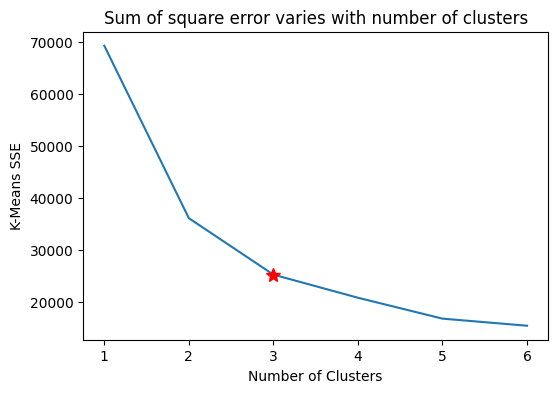

Visually pick 3 clusters at the elbow.


In [15]:
# K-Means
# Clustering
numClusters = [1,2,3,4,5,6]

# Sum of Square Error
SSE_k = []
for i in numClusters:
    k_means = cluster.KMeans(n_clusters=i, max_iter=50, random_state=1)
    k_means.fit(cluster_attribute) 
    SSE_k.append(k_means.inertia_)

plt.figure(figsize=(6,4))
plt.plot(numClusters, SSE_k)
plt.plot(3, SSE_k[2], marker='*', markersize=10, c='red')
plt.xlabel('Number of Clusters')
plt.ylabel('K-Means SSE')
plt.title('Sum of square error varies with number of clusters')
plt.show()

print('Visually pick 3 clusters at the elbow.')

In [16]:
# K-Means 3 clusters
k_means_3 = cluster.KMeans(n_clusters=3, max_iter=50, random_state=1)
k_means_3.fit(cluster_attribute) 
label_3_k = k_means_3.labels_
clustered_3_k = pd.DataFrame(label_3_k, columns=['K-Means 3 clusters'])

# Agglomerative (top up) 3 clusters
agg_3 = cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
agg_3.fit(cluster_attribute) 
label_3_agg = agg_3.labels_
clustered_3_agg = pd.DataFrame(label_3_agg, columns=['Agglomerative (top up) 3 clusters'])

clustered_3 = pd.concat([pc, clustered_3_k, clustered_3_agg], axis=1)
clustered_3

,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),hard mode percentage,PC1,PC2,Average try,K-Means 3 clusters,Agglomerative (top up) 3 clusters
0,0,2,17,37,29,12,2,0.0932,0.442487,31.577824,4.834233,2,2
1,0,4,21,38,26,9,1,0.0930,6.727548,30.965346,4.600471,2,0
2,0,2,16,38,30,12,2,0.0959,-0.422768,32.842243,4.864869,2,2
3,0,3,21,40,25,9,1,0.0961,7.329319,32.271812,4.625874,2,0
4,0,2,17,35,29,14,3,0.0964,-1.180205,29.293504,4.933374,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,1,9,35,34,16,5,1,0.0196,22.496977,21.370515,3.816652,1,0
349,1,4,16,30,30,17,2,0.0209,-4.084271,25.307378,4.543984,2,2
350,1,3,13,27,30,22,4,0.0209,-9.807015,21.934407,4.778841,0,1
351,1,5,23,31,24,14,2,0.0174,4.976647,22.945429,4.314422,2,2


In [17]:
# Convert into easy, medium, and hard
label_avg_try_k = []
label_avg_try_agg = []
hard_level = np.array(['Easy', 'Medium', 'Hard'])
# Average try in each label
for i in range(3):
    label_avg_try_k.append(np.average(clustered_3['Average try'].values[label_3_k==i]))
    label_avg_try_agg.append(np.average(clustered_3['Average try'].values[label_3_agg==i]))

# Sort by average and level the difficulty
indice_k = np.argsort(label_avg_try_k)
indice_agg = np.argsort(label_avg_try_agg)
hard_level_k = [hard_level[indice_k==label_3_k[i]] for i in range(label_3_k.shape[0])]
hard_level_agg = [hard_level[indice_agg==label_3_agg[i]] for i in range(label_3_agg.shape[0])]

# Add to dataframe
hard_level_k = pd.DataFrame(np.array(hard_level_k), columns=['K-Means'])
hard_level_agg = pd.DataFrame(np.array(hard_level_agg), columns=['Agglomerative (top up)'])
clustered_3_hard_level = pd.concat([clustered_3, hard_level_k, hard_level_agg], axis=1)

# Represent hard level by number
clustered_3_hard_level['K-Means color level'] = clustered_3_hard_level['K-Means'].factorize(sort=True)[0] #  Sort by uniques
clustered_3_hard_level['Agglomerative (top up) color level'] = clustered_3_hard_level['Agglomerative (top up)'].factorize(sort=True)[0]
level_str = 'Color level: [0, 1, 2] --> ' + str(clustered_3_hard_level['K-Means'].factorize(sort=True)[1].values)
print(level_str)
clustered_3_hard_level

Color level: [0, 1, 2] --> ['Easy' 'Hard' 'Medium']


,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),hard mode percentage,PC1,PC2,Average try,K-Means 3 clusters,Agglomerative (top up) 3 clusters,K-Means,Agglomerative (top up),K-Means color level,Agglomerative (top up) color level
0,0,2,17,37,29,12,2,0.0932,0.442487,31.577824,4.834233,2,2,Medium,Medium,2,2
1,0,4,21,38,26,9,1,0.0930,6.727548,30.965346,4.600471,2,0,Medium,Easy,2,0
2,0,2,16,38,30,12,2,0.0959,-0.422768,32.842243,4.864869,2,2,Medium,Medium,2,2
3,0,3,21,40,25,9,1,0.0961,7.329319,32.271812,4.625874,2,0,Medium,Easy,2,0
4,0,2,17,35,29,14,3,0.0964,-1.180205,29.293504,4.933374,2,2,Medium,Medium,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,1,9,35,34,16,5,1,0.0196,22.496977,21.370515,3.816652,1,0,Easy,Easy,0,0
349,1,4,16,30,30,17,2,0.0209,-4.084271,25.307378,4.543984,2,2,Medium,Medium,2,2
350,1,3,13,27,30,22,4,0.0209,-9.807015,21.934407,4.778841,0,1,Hard,Hard,1,1
351,1,5,23,31,24,14,2,0.0174,4.976647,22.945429,4.314422,2,2,Medium,Medium,2,2


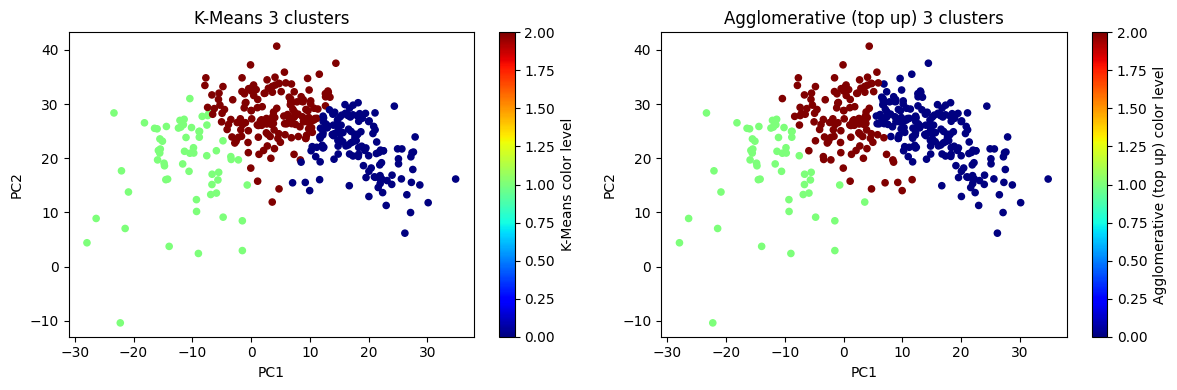

Color level: [0, 1, 2] --> ['Easy' 'Hard' 'Medium']


In [18]:
# Visualize
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
clustered_3_hard_level.plot.scatter(x='PC1',y='PC2',c='K-Means color level',colormap='jet',ax=ax[0])
ax[0].set_title('K-Means 3 clusters')
clustered_3_hard_level.plot.scatter(x='PC1',y='PC2',c='Agglomerative (top up) color level',colormap='jet',ax=ax[1])
ax[1].set_title('Agglomerative (top up) 3 clusters')
plt.tight_layout()
plt.show()
print(level_str)

In [19]:
# EERIE
# Use random forest with depth: 10, 500 estimators
model_rf=RegressorChain(RandomForestRegressor(max_depth=10,n_estimators=500,random_state=0))
model_rf.fit(tr_x,tr_y)   

RegressorChain(base_estimator=RandomForestRegressor(max_depth=10,
                                                    n_estimators=500,
                                                    random_state=0))

In [20]:
# X = data[['hard mode percentage', 'encode_1', 'encode_2', 'encode_3', 'encode_4', 'encode_5', 'vowel_num', 'dup_num', 'e12', 't9', 'a8', 'o7', 'i7', 'n7']]
# The hard mode percent is set to 0.01
EERIE_x = np.array([0.01, 5, 5, 18, 9, 5, 4, 3, 1, 0, 0, 0, 1, 0]).reshape(1,-1)
# Predict try
EERIE_y = model_rf.predict(EERIE_x)
EERIE_y = pd.DataFrame(EERIE_y, columns=[['1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7 or more tries (X)']])
EERIE_y['hard mode percentage'] = 0.01
EERIE_y

,1 try,2 tries,3 tries,4 tries,5 tries,6 tries,7 or more tries (X),hard mode percentage
0,0.986,4.330629,17.983806,30.404184,26.850732,16.28346,3.563967,0.01


In [21]:
# Difficulty
# K-Means
EERIE_y_k = k_means_3.predict(EERIE_y)
EERIE_hard_level_k = hard_level[indice_k==EERIE_y_k]
print('Word EERIE is identified as', EERIE_hard_level_k)

Word EERIE is identified as ['Medium']


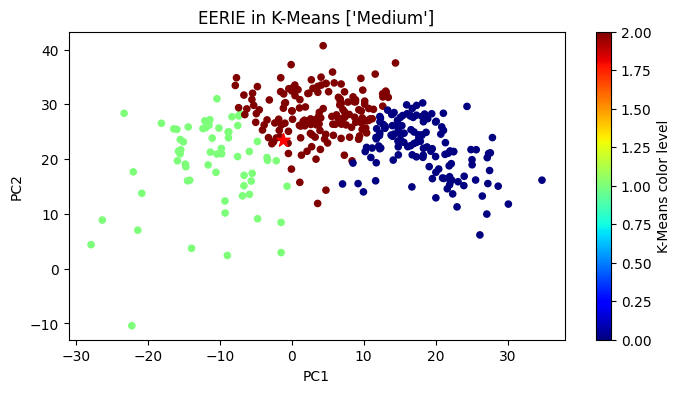

Color level: [0, 1, 2] --> ['Easy' 'Hard' 'Medium']


In [22]:
# Visualize
# Project to pc
EERIE_pc = (EERIE_y.values * n_eigVect).A
# Color level in cmap
EERIE_color = np.where(clustered_3_hard_level['K-Means'].factorize(sort=True)[1].values == EERIE_hard_level_k[0])[0][0]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4))
clustered_3_hard_level.plot.scatter(x='PC1',y='PC2',c='K-Means color level',cmap='jet',ax=ax)
ax.scatter(x=EERIE_pc[0][0],y=EERIE_pc[0][1],c='red',s=100,marker='*')
ax.set_title('EERIE in K-Means '+str(EERIE_hard_level_k))
plt.show()
print(level_str)

In [23]:
#########################################################
##################### END: OWN CODE #####################
#########################################################